In [1]:
# Kết nối Google Drive (nếu chạy trong Colab)
try:
    from google.colab import drive
    print("Kết nối Google Drive...")
    drive.mount('/content/drive')
except:
    print("Không thể kết nối Google Drive hoặc không chạy trong môi trường Colab.")

Kết nối Google Drive...
Mounted at /content/drive


In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# **Preprocess data**

In [3]:
def downsample_signal(signal_data, original_fs=300, target_fs=125):
    """
    Downsample tín hiệu từ tần số gốc xuống tần số mục tiêu

    Parameters:
    signal_data: array - Tín hiệu đầu vào
    original_fs: int - Tần số lấy mẫu ban đầu (Hz)
    target_fs: int - Tần số lấy mẫu mục tiêu (Hz)

    Returns:
    array - Tín hiệu đã được downsample
    """
    # Tính số mẫu mới
    new_length = int(len(signal_data) * target_fs / original_fs)

    # Sử dụng Fourier method để resample
    resampled_signal = signal.resample(signal_data, new_length)

    return resampled_signal

In [4]:
def load_mat_file(file_path):
    """Đọc dữ liệu từ file .mat"""
    try:
        with h5py.File(file_path, 'r') as mat_data:
            # In các khóa để debug
            print(f"Đang đọc file: {file_path}")
            print("Các khóa trong file:", list(mat_data.keys()))

            # Trích xuất tín hiệu
            try:
                ppg_signal = mat_data['signal']['pleth']['y'][0]
            except Exception as e:
                print(f"Lỗi trích xuất PPG: {e}")
                ppg_signal = None

            try:
                hr_ecg = mat_data['reference']['hr']['ecg']['y'][:]
            except Exception as e:
                print(f"Lỗi trích xuất HR: {e}")
                hr_ecg = None

            try:
                fs_pleth = mat_data['param']['samplingrate']['pleth'][0,0]
            except Exception as e:
                print(f"Lỗi trích xuất tần số lấy mẫu: {e}")
                fs_pleth = 125  # Giá trị mặc định

            # Kiểm tra dữ liệu
            if ppg_signal is None or hr_ecg is None:
                print(f"Dữ liệu không đầy đủ trong file {file_path}")
                return None

            # Downsample tín hiệu PPG từ 300Hz xuống 125Hz
            if fs_pleth == 300:
                ppg_signal = downsample_signal(ppg_signal, original_fs=300, target_fs=125)
                fs_pleth = 125
                print(f"Đã downsample tín hiệu từ 300Hz xuống 125Hz")

            return {
                'ppg_signal': ppg_signal,
                'hr_ecg': hr_ecg,
                'fs': fs_pleth,
                'file_name': os.path.basename(file_path)
            }
    except Exception as e:
        print(f"Lỗi khi mở file {file_path}: {e}")
        return None

In [5]:
def filter_signal(signal_data, fs=125, low_cutoff=0.5, high_cutoff=8.0):
    """Lọc tín hiệu với bộ lọc băng thông"""
    nyquist = fs / 2
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, signal_data)
    return filtered_signal

In [6]:
def collect_all_data(folder_path):
    """Bước 1: Tổng hợp tất cả các file .mat thành một tập dữ liệu"""
    all_data = []

    # Lặp qua các file .mat trong thư mục
    for filename in os.listdir(folder_path):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder_path, filename)
            file_data = load_mat_file(file_path)

            if file_data:
                all_data.append(file_data)
                print(f"Đã đọc thành công file {filename}")
                print(f"Độ dài tín hiệu PPG: {len(file_data['ppg_signal'])}")
                print(f"Độ dài tín hiệu HR: {len(file_data['hr_ecg'])}")
                print(f"Tần số lấy mẫu: {file_data['fs']} Hz")
                print("-" * 50)

    print(f"Tổng số file đã đọc: {len(all_data)}")
    return all_data

In [7]:
def segment_all_signals(all_data, segment_length=750, overlap=0.5):
    """Phân đoạn tất cả tín hiệu mà không lọc theo HR"""
    all_ppg_segments = []
    all_ppg_normalized = []
    all_hr_raw = []

    for data in all_data:
        ppg_signal = data['ppg_signal']
        hr_values = data['hr_ecg'].flatten()
        fs = data['fs']

        # Lọc tín hiệu PPG
        filtered_ppg = filter_signal(ppg_signal, fs=fs)

        # Phân đoạn
        step = int(segment_length * (1 - overlap))
        num_segments = (len(filtered_ppg) - segment_length) // step + 1

        print(f"Xử lý file {data['file_name']}: {num_segments} đoạn")

        for j in range(num_segments):
            start = j * step
            end = start + segment_length

            if end <= len(filtered_ppg):
                # Lấy đoạn tín hiệu
                ppg_seg = filtered_ppg[start:end]

                # Tính vị trí tương ứng trong mảng HR
                hr_start_idx = int(start / len(ppg_signal) * len(hr_values))
                hr_end_idx = int(end / len(ppg_signal) * len(hr_values))

                # Đảm bảo chỉ số không vượt quá giới hạn
                hr_start_idx = min(hr_start_idx, len(hr_values) - 1)
                hr_end_idx = min(hr_end_idx, len(hr_values))

                # Lấy đoạn HR tương ứng
                segment_hr_values = hr_values[hr_start_idx:hr_end_idx]

                # Nếu không có giá trị HR nào, sử dụng giá trị gần nhất
                if len(segment_hr_values) == 0:
                    segment_hr = hr_values[hr_start_idx]
                else:
                    # Tính giá trị trung bình của HR trong đoạn
                    segment_hr = np.mean(segment_hr_values)

                # Chuẩn hóa PPG về [-1, 1]
                scaler = MinMaxScaler(feature_range=(-1, 1))
                ppg_seg_normalized = scaler.fit_transform(ppg_seg.reshape(-1, 1)).flatten()

                all_ppg_segments.append(ppg_seg)
                all_ppg_normalized.append(ppg_seg_normalized)
                all_hr_raw.append(segment_hr)

    # Chuyển về numpy array
    all_ppg_segments = np.array(all_ppg_segments)
    all_ppg_normalized = np.array(all_ppg_normalized)
    all_hr_raw = np.array(all_hr_raw)

    # Vẽ phân phối HR của tất cả các đoạn
    plt.figure(figsize=(15, 6))
    plt.hist(all_hr_raw, bins=30, alpha=0.7, color='blue')
    plt.title("Phân phối HR của tất cả các đoạn")
    plt.xlabel("HR (BPM)")
    plt.ylabel("Số lượng")
    plt.grid(True)
    plt.show()

    # Tính thống kê HR
    hr_mean = np.mean(all_hr_raw)
    hr_std = np.std(all_hr_raw)
    hr_min = np.min(all_hr_raw)
    hr_max = np.max(all_hr_raw)

    print(f"Thống kê HR:")
    print(f"Mean: {hr_mean:.2f} BPM")
    print(f"Std: {hr_std:.2f} BPM")
    print(f"Min: {hr_min:.2f} BPM")
    print(f"Max: {hr_max:.2f} BPM")

    print(f"Tổng số đoạn: {len(all_ppg_segments)}")
    print(f"Độ dài mỗi segment: {segment_length} điểm (~{segment_length/125:.2f} giây ở 125Hz)")

    # Vẽ một số đoạn PPG
    plt.figure(figsize=(15, 10))

    # Vẽ 5 đoạn PPG đầu tiên
    for i in range(min(5, len(all_ppg_segments))):
        plt.subplot(5, 1, i+1)
        plt.plot(all_ppg_segments[i])
        plt.title(f"Đoạn PPG {i+1} - HR trung bình: {all_hr_raw[i]:.2f} BPM")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return all_ppg_segments, all_ppg_normalized, all_hr_raw

In [8]:
def prepare_data_loaders(ppg_segments, ppg_normalized, hr_raw):
    """Chuẩn bị DataLoader cho huấn luyện"""
    # Chia train/test
    train_size = int(0.8 * len(ppg_segments))
    indices = np.random.permutation(len(ppg_segments))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    X_train = ppg_segments[train_indices]
    X_test = ppg_segments[test_indices]

    X_train_norm = ppg_normalized[train_indices]
    X_test_norm = ppg_normalized[test_indices]

    hr_raw_train = hr_raw[train_indices]
    hr_raw_test = hr_raw[test_indices]

    # Chuẩn bị DataLoader
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_norm),
        torch.FloatTensor(hr_raw_train.reshape(-1, 1))
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = TensorDataset(
        torch.FloatTensor(X_test_norm),
        torch.FloatTensor(hr_raw_test.reshape(-1, 1))
    )
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Xuất thông tin
    print("\nThông tin xử lý:")
    print(f"Tổng số đoạn PPG: {len(ppg_segments)}")
    print(f"Kích thước tập train: {X_train.shape}")
    print(f"Kích thước tập test: {X_test.shape}")

    return train_loader, test_loader, X_train, X_test, X_train_norm, X_test_norm, hr_raw_train, hr_raw_test

In [9]:
def process_mat_folder(folder_path):
    """Hàm chính để xử lý toàn bộ thư mục"""
    # Bước 1: Tổng hợp tất cả các file
    print("Bước 1: Đang tổng hợp dữ liệu từ tất cả các file...")
    all_data = collect_all_data(folder_path)

    if not all_data:
        raise ValueError("Không có dữ liệu nào được đọc từ thư mục")

    # Bước 2: Phân đoạn tất cả tín hiệu
    print("\nBước 2: Đang phân đoạn tất cả tín hiệu...")
    all_ppg_segments, all_ppg_normalized, all_hr_raw = segment_all_signals(all_data)

    # Chuẩn bị DataLoader
    print("\nĐang chuẩn bị DataLoader cho huấn luyện...")
    result = prepare_data_loaders(all_ppg_segments, all_ppg_normalized, all_hr_raw)

    return result

Bước 1: Đang tổng hợp dữ liệu từ tất cả các file...
Đang đọc file: /content/drive/MyDrive/cuoiky/capnobase/0103_8min.mat
Các khóa trong file: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
Đã downsample tín hiệu từ 300Hz xuống 125Hz
Đã đọc thành công file 0103_8min.mat
Độ dài tín hiệu PPG: 60000
Độ dài tín hiệu HR: 825
Tần số lấy mẫu: 125 Hz
--------------------------------------------------
Đang đọc file: /content/drive/MyDrive/cuoiky/capnobase/0030_8min.mat
Các khóa trong file: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
Đã downsample tín hiệu từ 300Hz xuống 125Hz
Đã đọc thành công file 0030_8min.mat
Độ dài tín hiệu PPG: 60000
Độ dài tín hiệu HR: 867
Tần số lấy mẫu: 125 Hz
--------------------------------------------------
Đang đọc file: /content/drive/MyDrive/cuoiky/capnobase/0023_8min.mat
Các khóa trong file: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
Đã downsample tín hiệu từ 300Hz xuống 125Hz


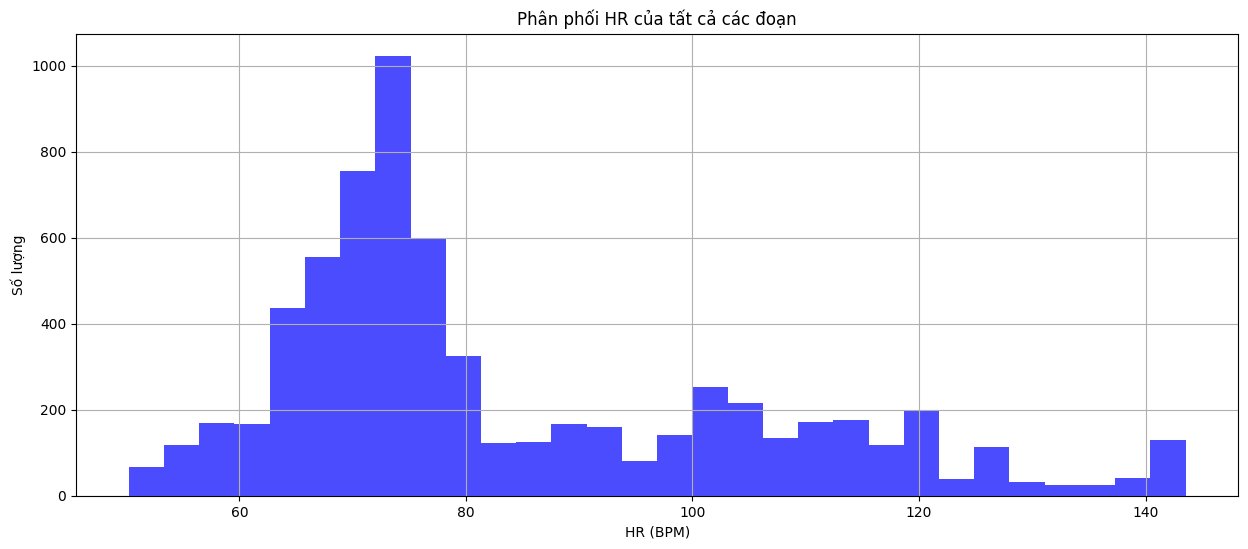

Thống kê HR:
Mean: 83.95 BPM
Std: 21.07 BPM
Min: 50.23 BPM
Max: 143.53 BPM
Tổng số đoạn: 6678
Độ dài mỗi segment: 750 điểm (~6.00 giây ở 125Hz)


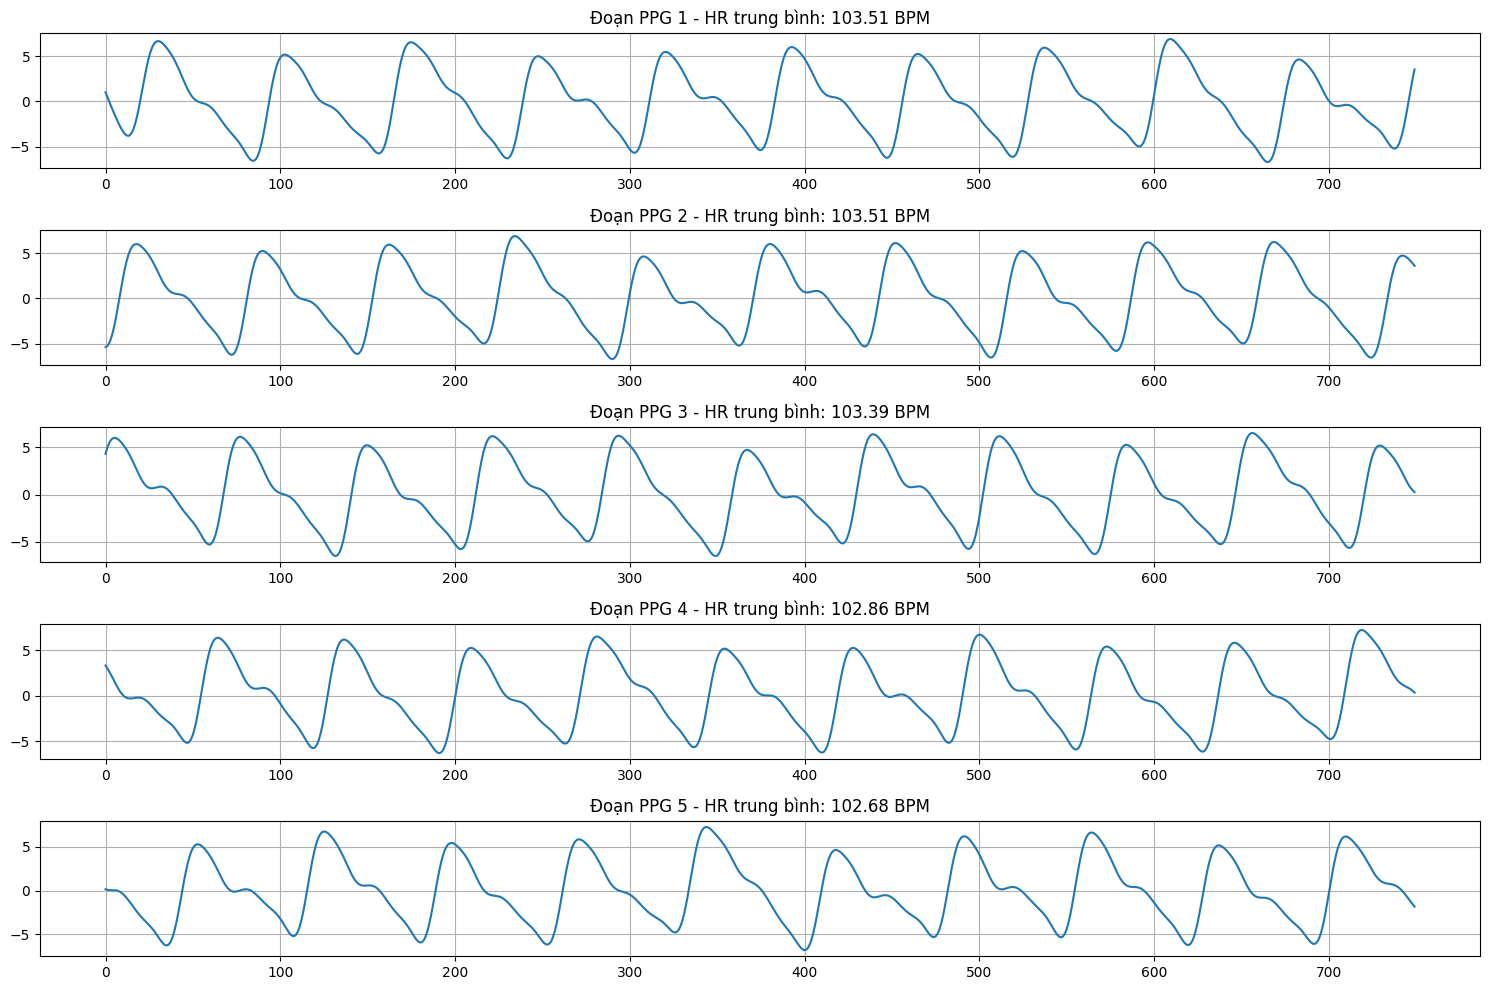


Đang chuẩn bị DataLoader cho huấn luyện...

Thông tin xử lý:
Tổng số đoạn PPG: 6678
Kích thước tập train: (5342, 750)
Kích thước tập test: (1336, 750)
Đã lưu dữ liệu vào file 'processed_capno_data.mat'

Shape của các dữ liệu:
X_train shape: (5342, 750)
X_test shape: (1336, 750)
X_train_norm shape: (5342, 750)
X_test_norm shape: (1336, 750)
hr_raw_train shape: (5342,)
hr_raw_test shape: (1336,)


In [10]:
# Sử dụng
folder_path = '/content/drive/MyDrive/cuoiky/capnobase'
result = process_mat_folder(folder_path)
train_loader, test_loader, X_train, X_test, X_train_norm, X_test_norm, hr_raw_train, hr_raw_test = result

# Lưu dữ liệu đã xử lý vào file .mat
import scipy.io as sio

# Tạo dictionary chứa tất cả dữ liệu cần lưu
data_to_save = {
    'X_train_norm': X_train_norm,
    'X_test_norm': X_test_norm,
    'hr_raw_train': hr_raw_train,
    'hr_raw_test': hr_raw_test,
    'X_total_norm': np.concatenate((X_train_norm, X_test_norm), axis=0),
    'hr_raw_total': np.concatenate((hr_raw_train, hr_raw_test), axis=0)
}

# Lưu vào file .mat
sio.savemat('processed_capno_data.mat', data_to_save)
print("Đã lưu dữ liệu vào file 'processed_capno_data.mat'")

# In ra shape của các dữ liệu
print("\nShape của các dữ liệu:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"hr_raw_train shape: {hr_raw_train.shape}")
print(f"hr_raw_test shape: {hr_raw_test.shape}")


Kiểm tra một số segment PPG và HR tương ứng:

Mẫu từ tập train:
Segment 0:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 66.38


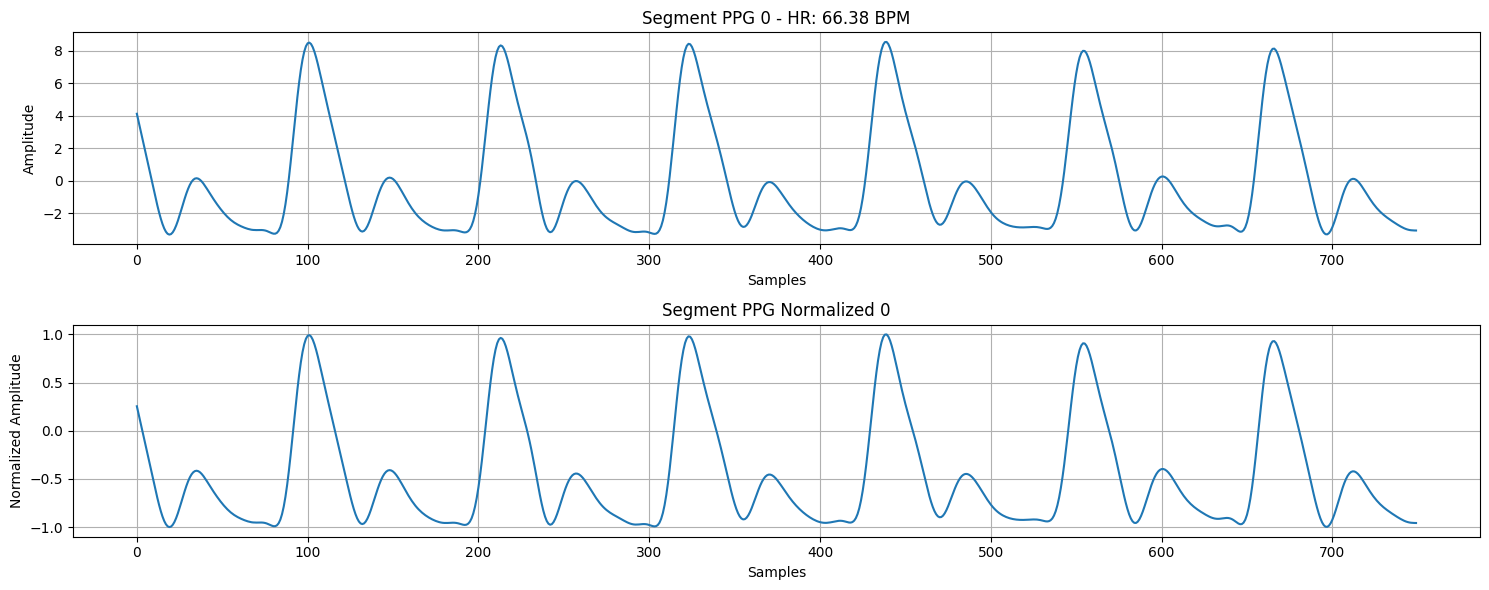

Segment 1:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 120.35


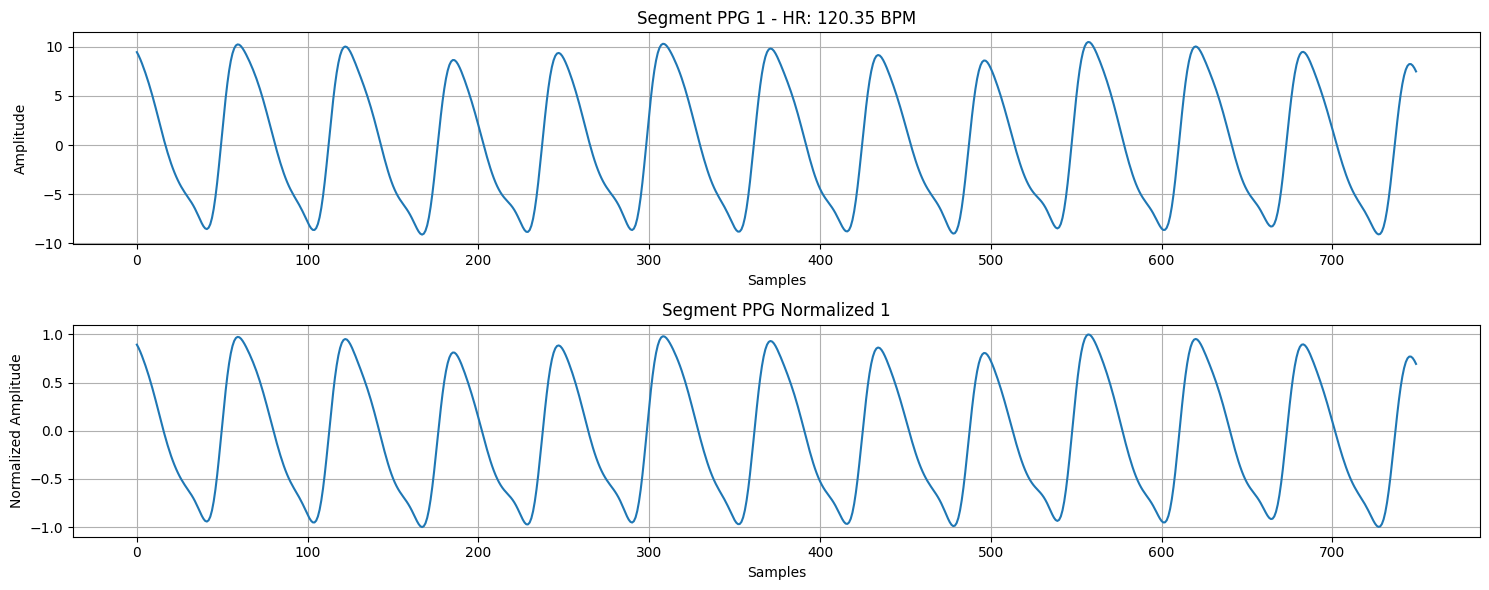

Segment 2:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 76.98


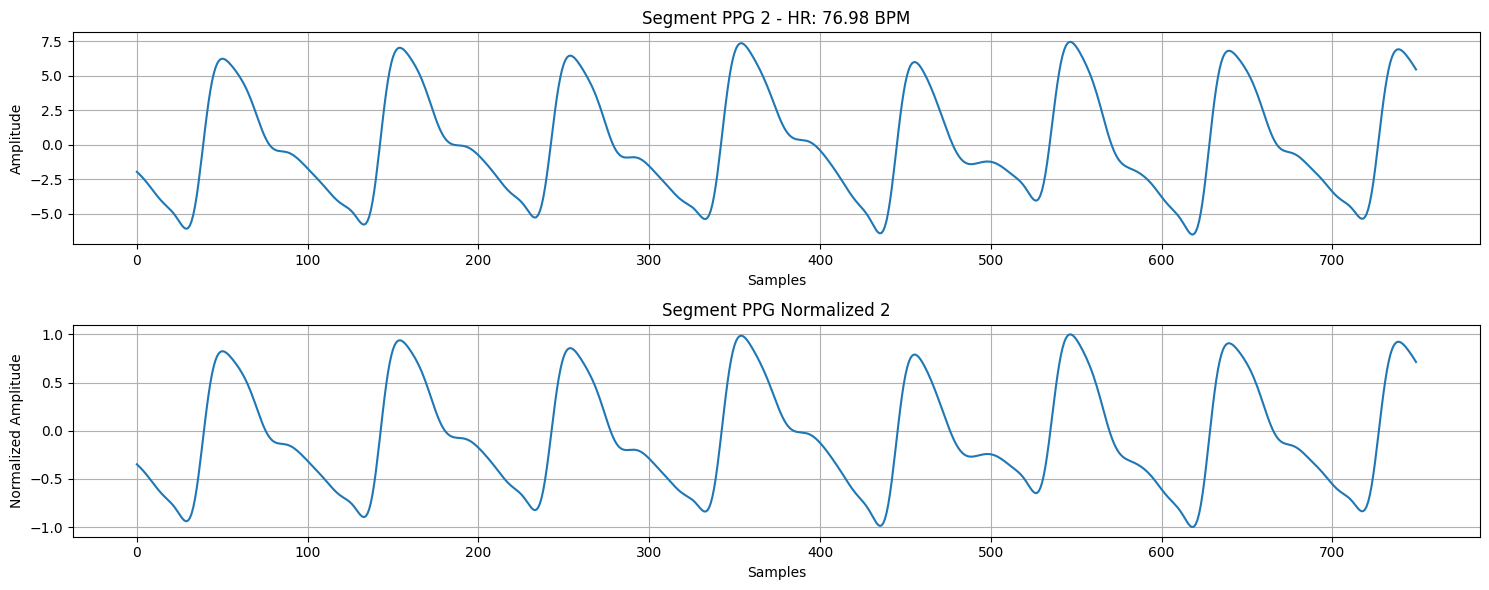

In [11]:
# Kiểm tra một vài segment PPG và giá trị HR tương ứng
print("\nKiểm tra một số segment PPG và HR tương ứng:")

# Lấy một vài mẫu ngẫu nhiên từ tập train
train_sample_indices = np.random.choice(len(X_train), size=3, replace=False)
print("\nMẫu từ tập train:")
for i, idx in enumerate(train_sample_indices):
    ppg_segment = X_train[idx]
    ppg_norm = X_train_norm[idx]
    hr_raw_value = hr_raw_train[idx]

    print(f"Segment {i}:")
    print(f"  - Độ dài segment PPG: {len(ppg_segment)}")
    print(f"  - Giá trị HR (BPM): {hr_raw_value:.2f}")

    # Vẽ segment PPG
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(ppg_segment)
    plt.title(f"Segment PPG {i} - HR: {hr_raw_value:.2f} BPM")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Vẽ segment PPG normalized
    plt.subplot(2, 1, 2)
    plt.plot(ppg_norm)
    plt.title(f"Segment PPG Normalized {i}")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Mẫu từ tập test:
Segment 0:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 77.63


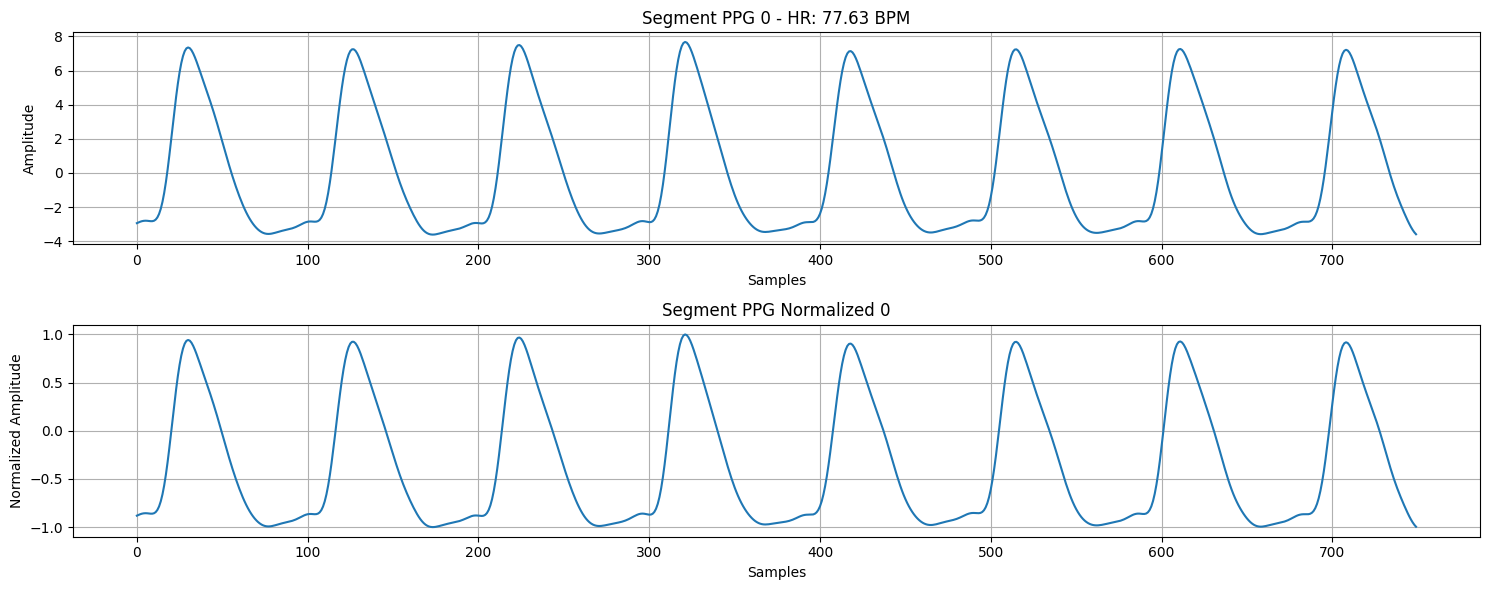

Segment 1:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 102.39


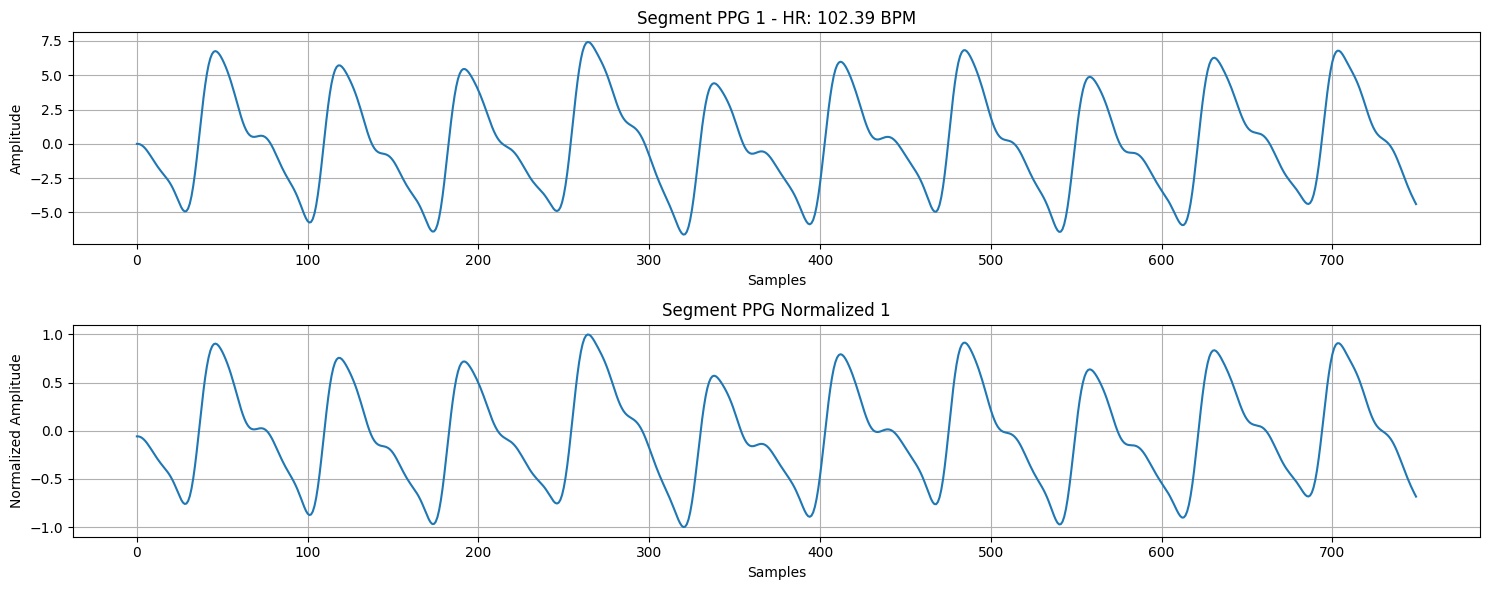

Segment 2:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 76.81


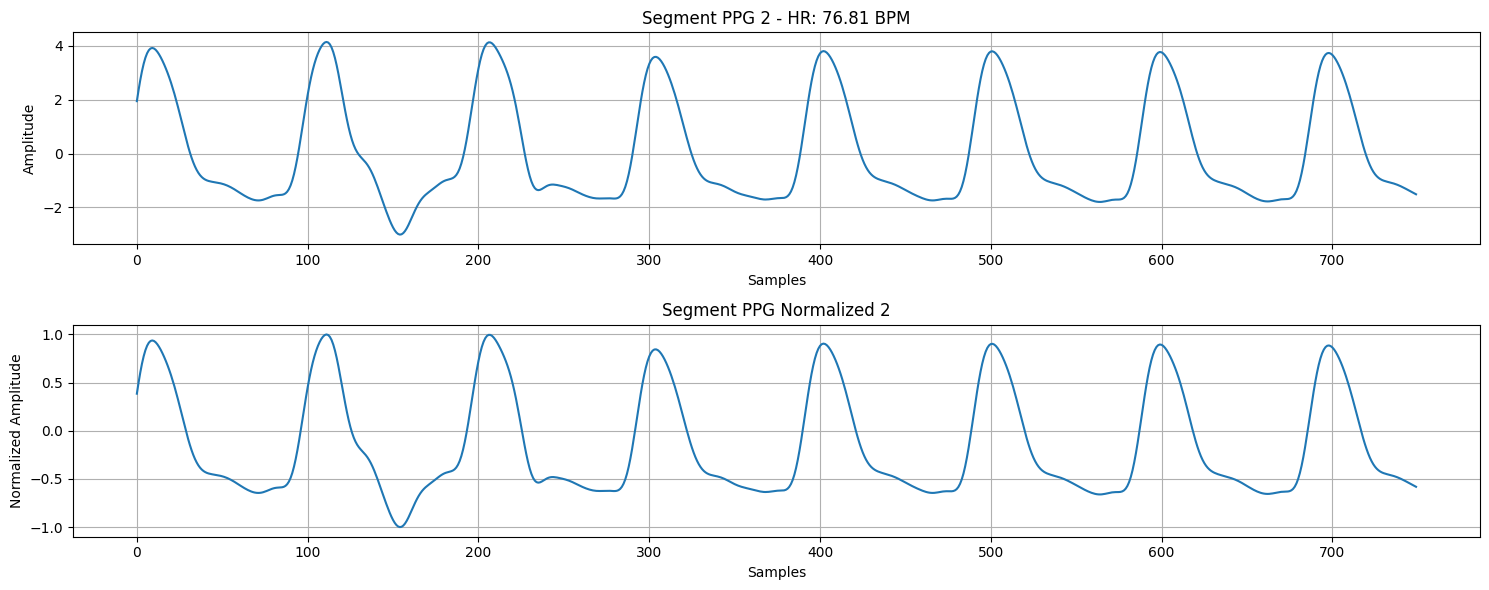

In [12]:
# Lấy một vài mẫu ngẫu nhiên từ tập test
test_sample_indices = np.random.choice(len(X_test), size=3, replace=False)
print("\nMẫu từ tập test:")
for i, idx in enumerate(test_sample_indices):
    ppg_segment = X_test[idx]
    ppg_norm = X_test_norm[idx]
    hr_raw_value = hr_raw_test[idx]

    print(f"Segment {i}:")
    print(f"  - Độ dài segment PPG: {len(ppg_segment)}")
    print(f"  - Giá trị HR (BPM): {hr_raw_value:.2f}")

    # Vẽ segment PPG
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(ppg_segment)
    plt.title(f"Segment PPG {i} - HR: {hr_raw_value:.2f} BPM")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Vẽ segment PPG normalized
    plt.subplot(2, 1, 2)
    plt.plot(ppg_norm)
    plt.title(f"Segment PPG Normalized {i}")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

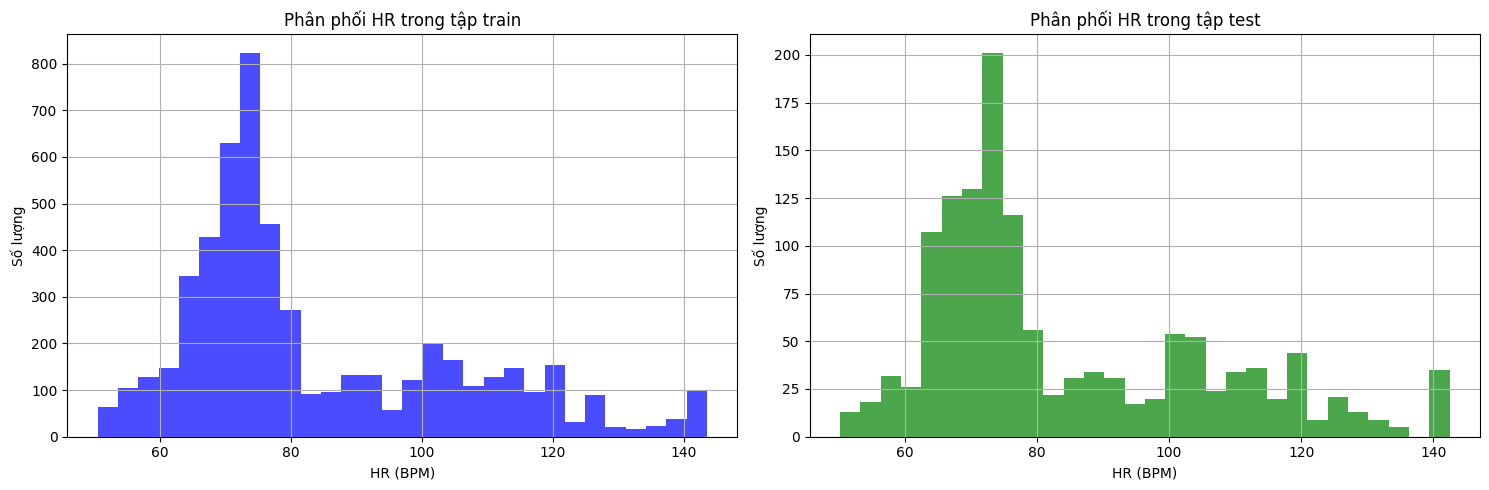

In [13]:
# Kiểm tra phân phối HR trong tập train và test
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(hr_raw_train, bins=30, alpha=0.7, color='blue')
plt.title("Phân phối HR trong tập train")
plt.xlabel("HR (BPM)")
plt.ylabel("Số lượng")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(hr_raw_test, bins=30, alpha=0.7, color='green')
plt.title("Phân phối HR trong tập test")
plt.xlabel("HR (BPM)")
plt.ylabel("Số lượng")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Load dữ liệu từ file .mat đã lưu
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [15]:
# Load dữ liệu từ file .mat
data = sio.loadmat('processed_capno_data.mat')

# Trích xuất các biến từ file
X_train_norm = data['X_train_norm']
X_test_norm = data['X_test_norm']
hr_raw_train = data['hr_raw_train']
hr_raw_test = data['hr_raw_test']
X_total_norm = data['X_total_norm']
hr_raw_total = data['hr_raw_total']

print(f"Đã load dữ liệu từ file 'processed_capno_data.mat'")
print(f"Kích thước X_train_norm: {X_train_norm.shape}")
print(f"Kích thước X_test_norm: {X_test_norm.shape}")
print(f"Kích thước hr_raw_train: {hr_raw_train.shape}")
print(f"Kích thước hr_raw_test: {hr_raw_test.shape}")

# Chuyển đổi dữ liệu sang tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train_norm)
X_test_tensor = torch.FloatTensor(X_test_norm)
hr_train_tensor = torch.FloatTensor(hr_raw_train)
hr_test_tensor = torch.FloatTensor(hr_raw_test)

# Kiểm tra và đảm bảo kích thước phù hợp
print(f"Kích thước X_train_tensor: {X_train_tensor.shape}")
print(f"Kích thước hr_train_tensor: {hr_train_tensor.shape}")
print(f"Kích thước X_test_tensor: {X_test_tensor.shape}")
print(f"Kích thước hr_test_tensor: {hr_test_tensor.shape}")

Đã load dữ liệu từ file 'processed_capno_data.mat'
Kích thước X_train_norm: (5342, 750)
Kích thước X_test_norm: (1336, 750)
Kích thước hr_raw_train: (1, 5342)
Kích thước hr_raw_test: (1, 1336)
Kích thước X_train_tensor: torch.Size([5342, 750])
Kích thước hr_train_tensor: torch.Size([1, 5342])
Kích thước X_test_tensor: torch.Size([1336, 750])
Kích thước hr_test_tensor: torch.Size([1, 1336])


In [16]:
# Đảm bảo hr_train_tensor và hr_test_tensor có cùng số mẫu với X_train_tensor và X_test_tensor
if hr_train_tensor.shape[0] != X_train_tensor.shape[0]:
    # Cắt bớt hoặc điều chỉnh kích thước để khớp nhau
    min_size = min(hr_train_tensor.shape[0], X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[:min_size]
    hr_train_tensor = hr_train_tensor[:min_size]
    print(f"Đã điều chỉnh kích thước train data: X={X_train_tensor.shape}, hr={hr_train_tensor.shape}")

if hr_test_tensor.shape[0] != X_test_tensor.shape[0]:
    # Cắt bớt hoặc điều chỉnh kích thước để khớp nhau
    min_size = min(hr_test_tensor.shape[0], X_test_tensor.shape[0])
    X_test_tensor = X_test_tensor[:min_size]
    hr_test_tensor = hr_test_tensor[:min_size]
    print(f"Đã điều chỉnh kích thước test data: X={X_test_tensor.shape}, hr={hr_test_tensor.shape}")

Đã điều chỉnh kích thước train data: X=torch.Size([1, 750]), hr=torch.Size([1, 5342])
Đã điều chỉnh kích thước test data: X=torch.Size([1, 750]), hr=torch.Size([1, 1336])


In [17]:
# Tạo dataset và dataloader
train_dataset = TensorDataset(X_train_tensor, hr_train_tensor)
test_dataset = TensorDataset(X_test_tensor, hr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Kiểm tra device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

Sử dụng device: cuda


# **MODEL**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat  # Thêm import loadmat từ scipy.io

In [19]:
# Load dữ liệu từ file .mat
print("Đang load dữ liệu từ file combined_data.mat...")
loaded_data = loadmat('processed_capno_data.mat')

# Trích xuất dữ liệu
X_train_loaded = loaded_data['X_train_norm']
X_test_loaded = loaded_data['X_test_norm']
hr_raw_train_loaded = loaded_data['hr_raw_train'].flatten()  # Flatten để chuyển từ (1, n) thành (n,)
hr_raw_test_loaded = loaded_data['hr_raw_test'].flatten()    # Flatten để chuyển từ (1, n) thành (n,)
X_total_loaded = loaded_data['X_total_norm']
hr_raw_total_loaded = loaded_data['hr_raw_total'].flatten()  # Flatten để chuyển từ (1, n) thành (n,)

# Kiểm tra kích thước dữ liệu đã load
print("\nShape của dữ liệu đã load:")
print(f"X_train_loaded shape: {X_train_loaded.shape}")
print(f"hr_raw_train_loaded shape: {hr_raw_train_loaded.shape}")
print(f"X_test_loaded shape: {X_test_loaded.shape}")
print(f"hr_raw_test_loaded shape: {hr_raw_test_loaded.shape}")
print(f"X_total_loaded shape: {X_total_loaded.shape}")
print(f"hr_raw_total_loaded shape: {hr_raw_total_loaded.shape}")

# Tính toán thống kê cho hr_raw_total_loaded
hr_raw_total_min = np.min(hr_raw_total_loaded)
hr_raw_total_max = np.max(hr_raw_total_loaded)
hr_raw_total_mean = np.mean(hr_raw_total_loaded)
hr_raw_total_std = np.std(hr_raw_total_loaded)

# In thống kê
print("\nThống kê HR raw total:")
print(f"Min: {hr_raw_total_min:.2f}, Max: {hr_raw_total_max:.2f}")
print(f"Mean: {hr_raw_total_mean:.2f}, Std: {hr_raw_total_std:.2f}")
print(f"Mean ± Std: {hr_raw_total_mean:.2f} ± {hr_raw_total_std:.2f}")

Đang load dữ liệu từ file combined_data.mat...

Shape của dữ liệu đã load:
X_train_loaded shape: (5342, 750)
hr_raw_train_loaded shape: (5342,)
X_test_loaded shape: (1336, 750)
hr_raw_test_loaded shape: (1336,)
X_total_loaded shape: (6678, 750)
hr_raw_total_loaded shape: (6678,)

Thống kê HR raw total:
Min: 50.23, Max: 143.53
Mean: 83.95, Std: 21.07
Mean ± Std: 83.95 ± 21.07


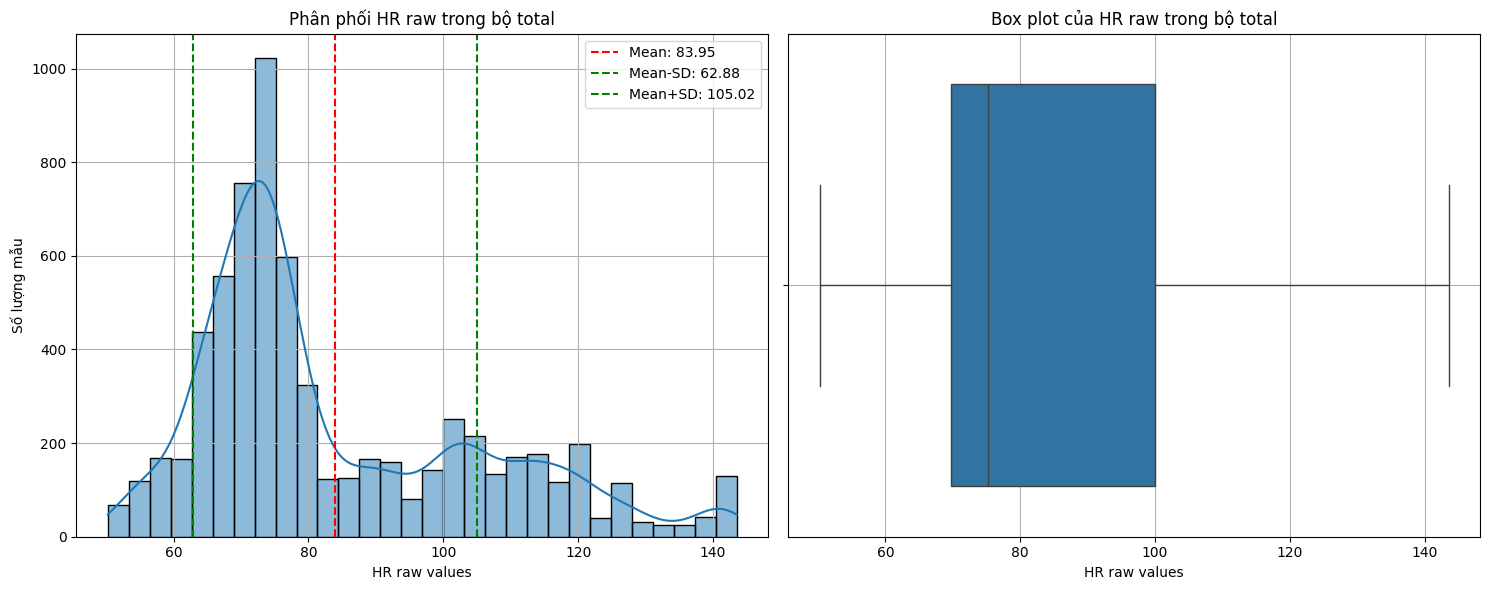

In [20]:
# Vẽ phân phối HR raw của bộ total
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(hr_raw_total_loaded, kde=True, bins=30)
plt.title('Phân phối HR raw trong bộ total')
plt.xlabel('HR raw values')
plt.ylabel('Số lượng mẫu')
plt.axvline(hr_raw_total_mean, color='r', linestyle='--', label=f'Mean: {hr_raw_total_mean:.2f}')
plt.axvline(hr_raw_total_mean - hr_raw_total_std, color='g', linestyle='--', label=f'Mean-SD: {hr_raw_total_mean - hr_raw_total_std:.2f}')
plt.axvline(hr_raw_total_mean + hr_raw_total_std, color='g', linestyle='--', label=f'Mean+SD: {hr_raw_total_mean + hr_raw_total_std:.2f}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=hr_raw_total_loaded)
plt.title('Box plot của HR raw trong bộ total')
plt.xlabel('HR raw values')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Lọc dữ liệu nằm trong phạm vi mean ± 2*std của HR raw total
hr_raw_lower_bound = hr_raw_total_mean - 2 * hr_raw_total_std
hr_raw_upper_bound = hr_raw_total_mean + 2 * hr_raw_total_std

print(f"\nLọc dữ liệu trong khoảng HR raw: [{hr_raw_lower_bound:.2f}, {hr_raw_upper_bound:.2f}]")

# Tạo mask cho các mẫu nằm trong khoảng cho toàn bộ dữ liệu total
valid_mask_total = np.logical_and(
    hr_raw_total_loaded >= hr_raw_lower_bound,
    hr_raw_total_loaded <= hr_raw_upper_bound
)

# Lọc dữ liệu total
X_total_filtered = X_total_loaded[valid_mask_total]
hr_raw_total_filtered = hr_raw_total_loaded[valid_mask_total]

# Chuẩn hóa HR raw về khoảng [0, 1] dựa trên mean và std đã biết
hr_raw_mean = hr_raw_total_mean
hr_raw_std = hr_raw_total_std


Lọc dữ liệu trong khoảng HR raw: [41.81, 126.09]


In [22]:
# Hàm chuẩn hóa HR raw về khoảng [0, 1]
def normalize_hr_raw(hr_raw_data, mean=hr_raw_mean, std=hr_raw_std):
    # Sử dụng min-max normalization để scale về [0, 1]
    # Lấy giá trị min và max từ dữ liệu đã lọc
    hr_min = hr_raw_lower_bound  # Sử dụng giá trị biên dưới đã lọc
    hr_max = hr_raw_upper_bound  # Sử dụng giá trị biên trên đã lọc

    # Công thức chuẩn hóa min-max: (x - min) / (max - min)
    normalized = (hr_raw_data - hr_min) / (hr_max - hr_min)

    # Đảm bảo giá trị nằm trong khoảng [0, 1]
    normalized = np.clip(normalized, 0, 1)

    return normalized

# Áp dụng chuẩn hóa cho dữ liệu total đã lọc
hr_raw_total_normalized = normalize_hr_raw(hr_raw_total_filtered)


Thống kê HR raw total sau khi chuẩn hóa:
Min: 0.0999, Max: 0.9999
Mean: 0.4687, Std: 0.2126


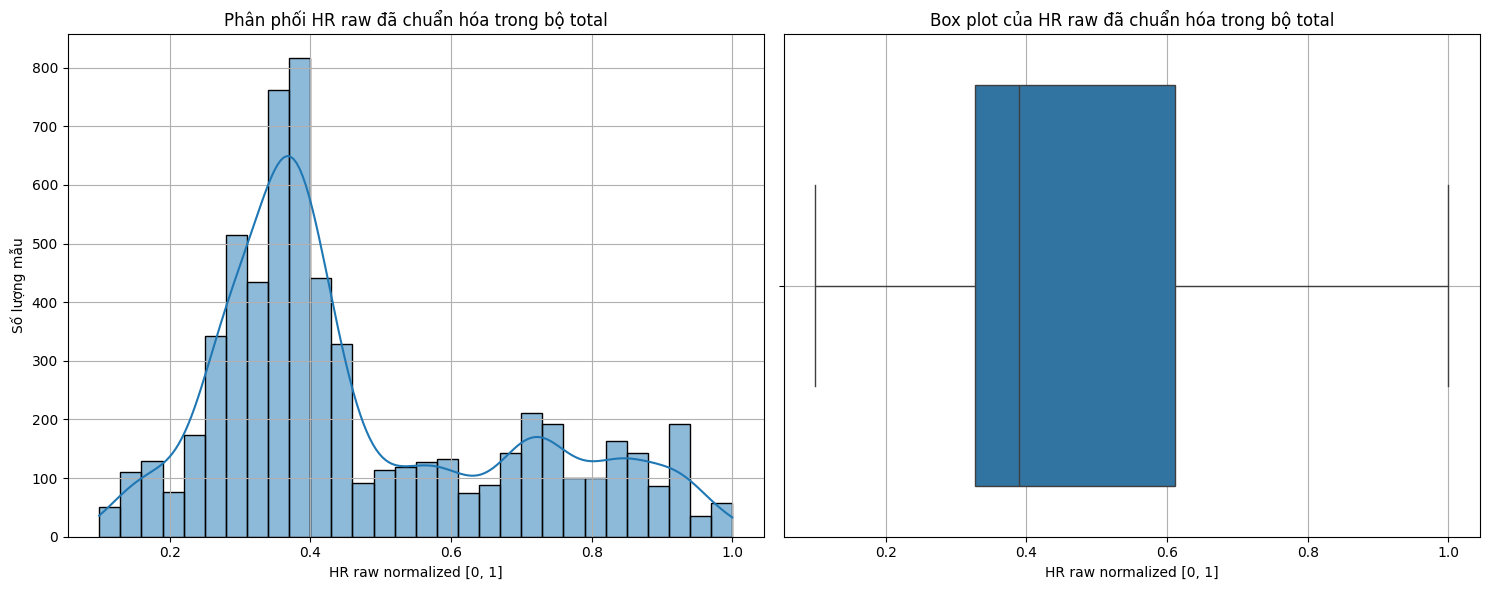

In [23]:
# Kiểm tra kết quả chuẩn hóa
print("\nThống kê HR raw total sau khi chuẩn hóa:")
print(f"Min: {np.min(hr_raw_total_normalized):.4f}, Max: {np.max(hr_raw_total_normalized):.4f}")
print(f"Mean: {np.mean(hr_raw_total_normalized):.4f}, Std: {np.std(hr_raw_total_normalized):.4f}")

# Vẽ phân phối HR raw sau khi chuẩn hóa
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(hr_raw_total_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ total')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=hr_raw_total_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ total')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
# Chia lại thành tập train và test từ dữ liệu total đã lọc và chuẩn hóa
from sklearn.model_selection import train_test_split

# Sử dụng tỷ lệ 80% train, 20% test
X_train_filtered, X_test_filtered, hr_raw_train_normalized, hr_raw_test_normalized = train_test_split(
    X_total_filtered, hr_raw_total_normalized, test_size=0.2, random_state=42
)

# Lấy giá trị HR raw gốc tương ứng cho việc hiển thị - Sửa lỗi MemoryError
# Thay vì tạo bản sao mới, sử dụng lại indices từ lần split trước
train_indices = np.arange(len(X_total_filtered))
train_indices, test_indices = train_test_split(
    train_indices, test_size=0.2, random_state=42
)
hr_raw_train_filtered = hr_raw_total_filtered[train_indices]
hr_raw_test_filtered = hr_raw_total_filtered[test_indices]

Số mẫu train ban đầu: 5342
Số mẫu train sau khi lọc: 5083
Tỷ lệ giữ lại (train): 95.15%
Số mẫu test ban đầu: 1336
Số mẫu test sau khi lọc: 1271
Tỷ lệ giữ lại (test): 95.13%

Thống kê HR raw sau khi chia tập:
Train - Min: 0.0999, Max: 0.9999
Train - Mean: 0.4681, Std: 0.2122
Test - Min: 0.1155, Max: 0.9999
Test - Mean: 0.4709, Std: 0.2142


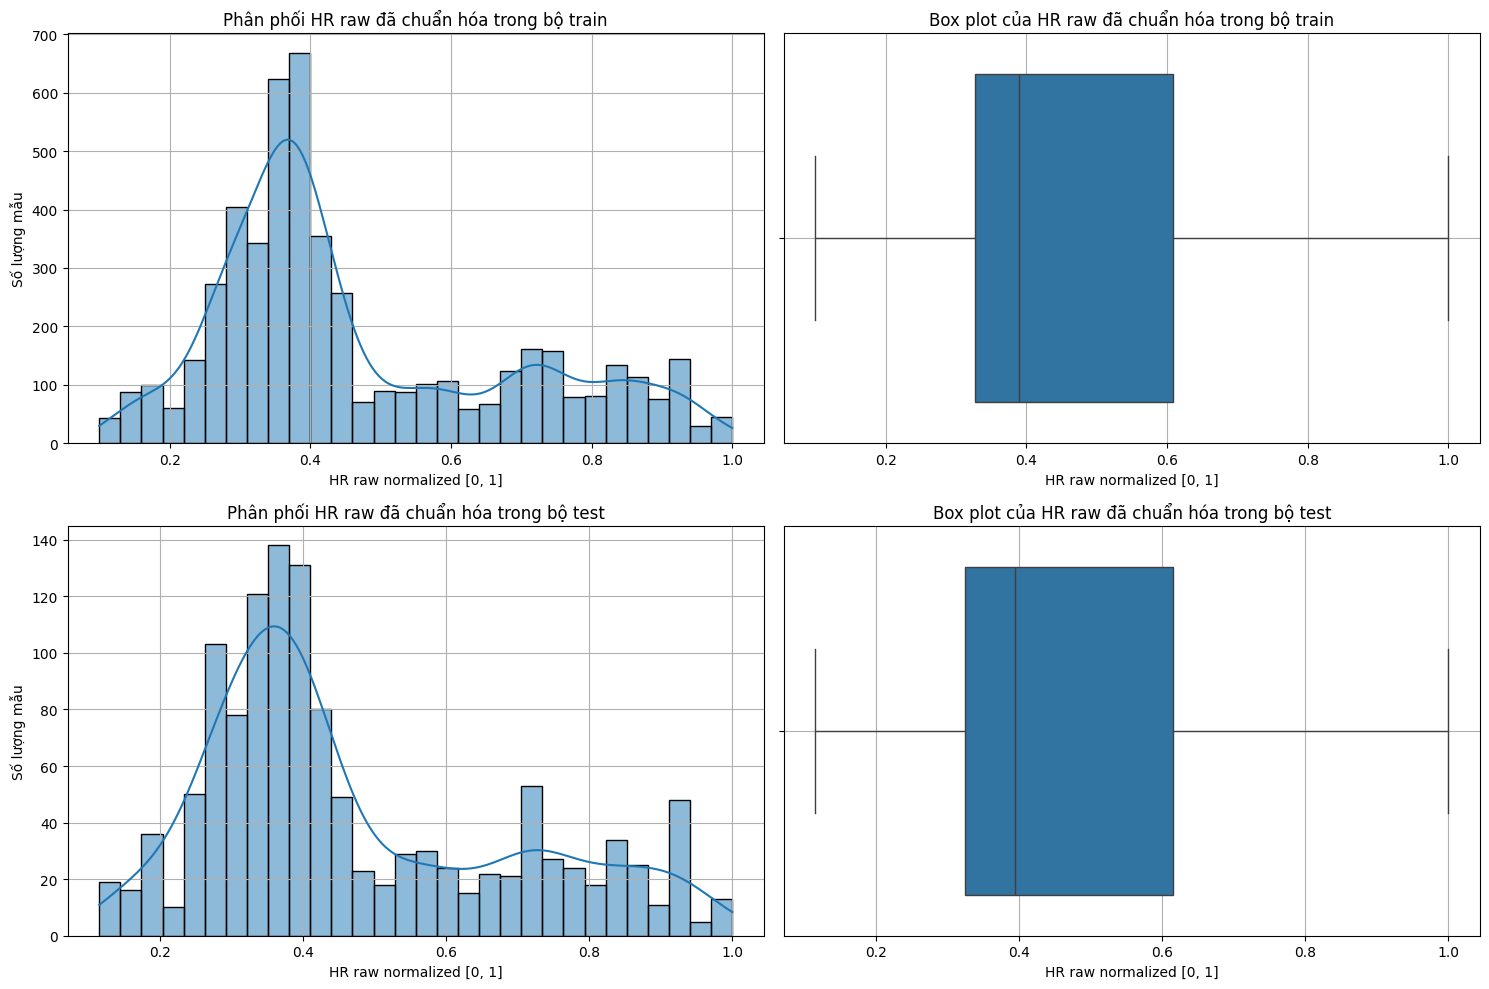

In [25]:
# In thông tin về số lượng mẫu đã lọc
print(f"Số mẫu train ban đầu: {X_train_loaded.shape[0]}")
print(f"Số mẫu train sau khi lọc: {X_train_filtered.shape[0]}")
print(f"Tỷ lệ giữ lại (train): {X_train_filtered.shape[0]/X_train_loaded.shape[0]*100:.2f}%")

print(f"Số mẫu test ban đầu: {X_test_loaded.shape[0]}")
print(f"Số mẫu test sau khi lọc: {X_test_filtered.shape[0]}")
print(f"Tỷ lệ giữ lại (test): {X_test_filtered.shape[0]/X_test_loaded.shape[0]*100:.2f}%")

# Kiểm tra thống kê HR raw sau khi chia tập
print("\nThống kê HR raw sau khi chia tập:")
print(f"Train - Min: {np.min(hr_raw_train_normalized):.4f}, Max: {np.max(hr_raw_train_normalized):.4f}")
print(f"Train - Mean: {np.mean(hr_raw_train_normalized):.4f}, Std: {np.std(hr_raw_train_normalized):.4f}")
print(f"Test - Min: {np.min(hr_raw_test_normalized):.4f}, Max: {np.max(hr_raw_test_normalized):.4f}")
print(f"Test - Mean: {np.mean(hr_raw_test_normalized):.4f}, Std: {np.std(hr_raw_test_normalized):.4f}")

# Vẽ phân phối HR raw sau khi chia tập
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(hr_raw_train_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ train')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.boxplot(x=hr_raw_train_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ train')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.histplot(hr_raw_test_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ test')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.boxplot(x=hr_raw_test_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ test')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.tight_layout()
plt.show()

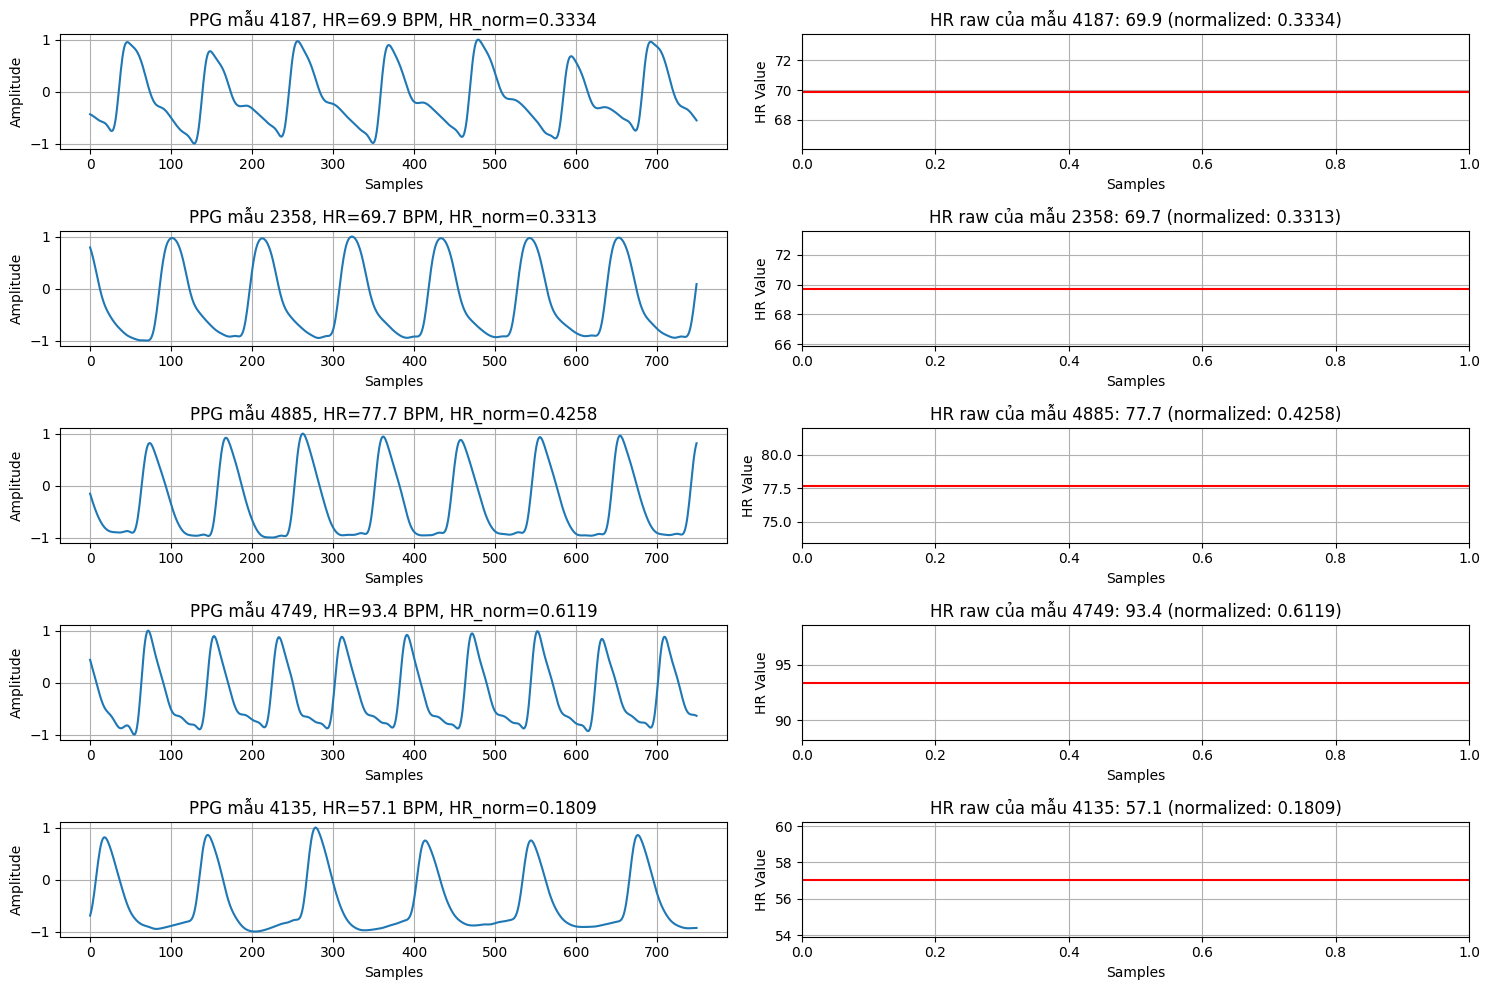

In [26]:
# Vẽ một vài mẫu để double check
plt.figure(figsize=(15, 10))
for i in range(5):
    idx = np.random.randint(0, X_train_filtered.shape[0])

    # Vẽ tín hiệu PPG
    plt.subplot(5, 2, i*2+1)
    plt.plot(X_train_filtered[idx])
    plt.title(f'PPG mẫu {idx}, HR={hr_raw_train_filtered[idx]:.1f} BPM, HR_norm={hr_raw_train_normalized[idx]:.4f}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Vẽ tín hiệu HR raw tương ứng
    plt.subplot(5, 2, i*2+2)
    plt.axhline(hr_raw_train_filtered[idx], color='r')
    plt.title(f'HR raw của mẫu {idx}: {hr_raw_train_filtered[idx]:.1f} (normalized: {hr_raw_train_normalized[idx]:.4f})')
    plt.xlabel('Samples')
    plt.ylabel('HR Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

# Giả sử dữ liệu đã được tiền xử lý như trong mã gốc
# Các biến như X_train_filtered, X_test_filtered, hr_raw_train_normalized, hr_raw_test_normalized đã được chuẩn bị
# Chuyển đổi dữ liệu thành tensor (không cần condition)
X_train_tensor = torch.FloatTensor(X_train_filtered)
X_test_tensor = torch.FloatTensor(X_test_filtered)

# Tạo dataset và dataloader (không cần condition)
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Thiết lập các tham số cho mô hình
input_size = X_train_filtered.shape[1]  # Kích thước của tín hiệu PPG
latent_dim = 64  # Kích thước không gian tiềm ẩn
hidden_dims = [256, 128, 64]  # Kích thước các lớp ẩn


Sử dụng device: cuda


In [28]:
# Định nghĩa lớp Sampling
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, args):
        z_mean, z_log_var = args
        batch_size = z_mean.size(0)
        latent_dim = z_mean.size(1)
        epsilon = torch.randn(batch_size, latent_dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [29]:
# Xây dựng Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[256, 128, 64]):
        super(Encoder, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.z_mean = nn.Linear(hidden_dims[-1], latent_dim)
        self.z_log_var = nn.Linear(hidden_dims[-1], latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [30]:
# Xây dựng Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dims=[64, 128, 256]):
        super(Decoder, self).__init__()
        self.input_layer = nn.Linear(latent_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, z):
        x = F.relu(self.input_layer(z))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = torch.tanh(self.output_layer(x))
        return x

In [31]:
# Xây dựng VAE
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def generate(self, z=None, batch_size=1):
        if z is None:
            z = torch.randn(batch_size, self.encoder.z_mean.out_features).to(device)
        return self.decoder(z)

In [32]:
# Khởi tạo mô hình
encoder = Encoder(input_size, latent_dim, hidden_dims)
decoder = Decoder(latent_dim, input_size, hidden_dims[::-1])
vae = VAE(encoder, decoder)

# Chuyển mô hình sang device
vae.to(device)

# Hiển thị cấu trúc mô hình
print("\n=== Cấu trúc Encoder ===")
print(encoder)
print("\n=== Cấu trúc Decoder ===")
print(decoder)
print("\n=== Cấu trúc VAE ===")
print(vae)

# Tính tổng số tham số của mô hình
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTổng số tham số của Encoder: {count_parameters(encoder):,}")
print(f"Tổng số tham số của Decoder: {count_parameters(decoder):,}")
print(f"Tổng số tham số của VAE: {count_parameters(vae):,}")


=== Cấu trúc Encoder ===
Encoder(
  (input_layer): Linear(in_features=750, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (z_mean): Linear(in_features=64, out_features=64, bias=True)
  (z_log_var): Linear(in_features=64, out_features=64, bias=True)
  (sampling): Sampling()
)

=== Cấu trúc Decoder ===
Decoder(
  (input_layer): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=750, bias=True)
)

=== Cấu trúc VAE ===
VAE(
  (encoder): Encoder(
    (input_layer): Linear(in_features=750, out_features=256, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Linear(in_features

In [33]:
# Định nghĩa hàm loss
def loss_function(x, x_recon, z_mean, z_log_var, kl_weight=0.5):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    loss = recon_loss + kl_weight * kl_loss
    return loss, recon_loss, kl_loss

# Định nghĩa các tham số huấn luyện
learning_rate = 1e-3
epochs = 600

# Khởi tạo optimizer và scheduler
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Khởi tạo danh sách để lưu lịch sử huấn luyện
train_losses = []
test_losses = []
recon_losses = []
kl_losses = []
best_loss = float('inf')

# Tham số cho early stopping
patience = 50
patience_counter = 0

# Tạo thư mục để lưu checkpoint
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [34]:
# Vòng lặp huấn luyện
for epoch in range(epochs):
    vae.train()
    total_train_loss = 0
    total_train_recon_loss = 0
    total_train_kl_loss = 0

    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_recon, z_mean, z_log_var = vae(data)
        loss, recon_loss, kl_loss = loss_function(data, x_recon, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * data.size(0)
        total_train_recon_loss += recon_loss.item() * data.size(0)
        total_train_kl_loss += kl_loss.item() * data.size(0)

    vae.eval()
    total_test_loss = 0
    total_test_recon_loss = 0
    total_test_kl_loss = 0

    with torch.no_grad():
        for data, in test_loader:
            data = data.to(device)
            x_recon, z_mean, z_log_var = vae(data)
            loss, recon_loss, kl_loss = loss_function(data, x_recon, z_mean, z_log_var)
            total_test_loss += loss.item() * data.size(0)
            total_test_recon_loss += recon_loss.item() * data.size(0)
            total_test_kl_loss += kl_loss.item() * data.size(0)

    train_loss = total_train_loss / len(train_loader.dataset)
    test_loss = total_test_loss / len(test_loader.dataset)
    train_recon_loss = total_train_recon_loss / len(train_loader.dataset)
    test_recon_loss = total_test_recon_loss / len(test_loader.dataset)
    train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
    test_kl_loss = total_test_kl_loss / len(test_loader.dataset)

    scheduler.step(test_loss)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    recon_losses.append(test_recon_loss)
    kl_losses.append(test_kl_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Recon Loss: {test_recon_loss:.4f}, KL Loss: {test_kl_loss:.4f}")

    if epoch % 50 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'vae_checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'recon_losses': recon_losses,
            'kl_losses': kl_losses
        }, checkpoint_path)

    if test_loss < best_loss:
        best_loss = test_loss
        best_model_path = 'best_vae_combined.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss
        }, best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping tại epoch {epoch} vì không có cải thiện sau {patience} epochs")
        break

# Lưu lịch sử huấn luyện
history = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_losses': recon_losses,
    'kl_losses': kl_losses
}
torch.save(history, 'training_history_vae.pth')

print("Huấn luyện hoàn tất!")

Epoch 0/600
Train Loss: 0.3866, Test Loss: 0.3747
Recon Loss: 0.3694, KL Loss: 0.0107
Epoch 10/600
Train Loss: 0.2493, Test Loss: 0.2463
Recon Loss: 0.2025, KL Loss: 0.0875
Epoch 20/600
Train Loss: 0.1927, Test Loss: 0.1925
Recon Loss: 0.1405, KL Loss: 0.1039
Epoch 30/600
Train Loss: 0.1533, Test Loss: 0.1547
Recon Loss: 0.0972, KL Loss: 0.1150
Epoch 40/600
Train Loss: 0.1368, Test Loss: 0.1422
Recon Loss: 0.0843, KL Loss: 0.1157
Epoch 50/600
Train Loss: 0.1302, Test Loss: 0.1353
Recon Loss: 0.0763, KL Loss: 0.1180
Epoch 60/600
Train Loss: 0.1265, Test Loss: 0.1320
Recon Loss: 0.0694, KL Loss: 0.1252
Epoch 70/600
Train Loss: 0.1244, Test Loss: 0.1322
Recon Loss: 0.0696, KL Loss: 0.1251
Epoch 80/600
Train Loss: 0.1225, Test Loss: 0.1286
Recon Loss: 0.0672, KL Loss: 0.1228
Epoch 90/600
Train Loss: 0.1205, Test Loss: 0.1289
Recon Loss: 0.0701, KL Loss: 0.1177
Epoch 100/600
Train Loss: 0.1196, Test Loss: 0.1269
Recon Loss: 0.0664, KL Loss: 0.1210
Epoch 110/600
Train Loss: 0.1176, Test Loss

# **Đánh giá mô hình**

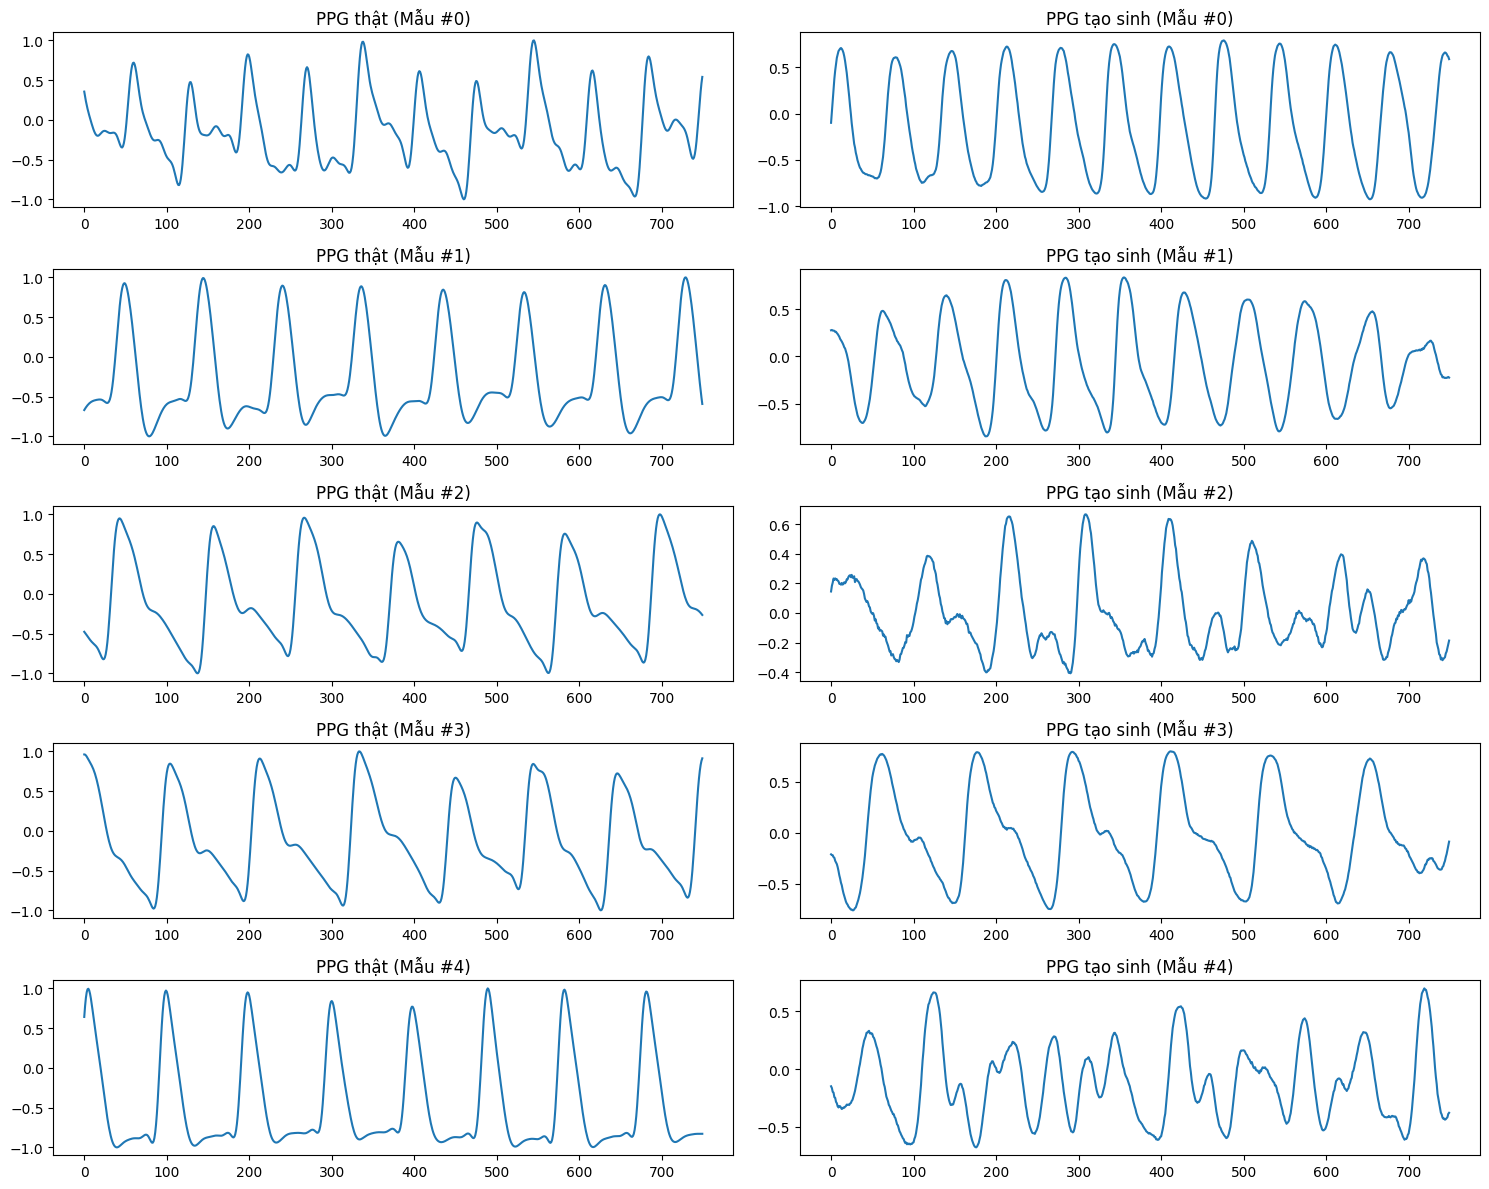

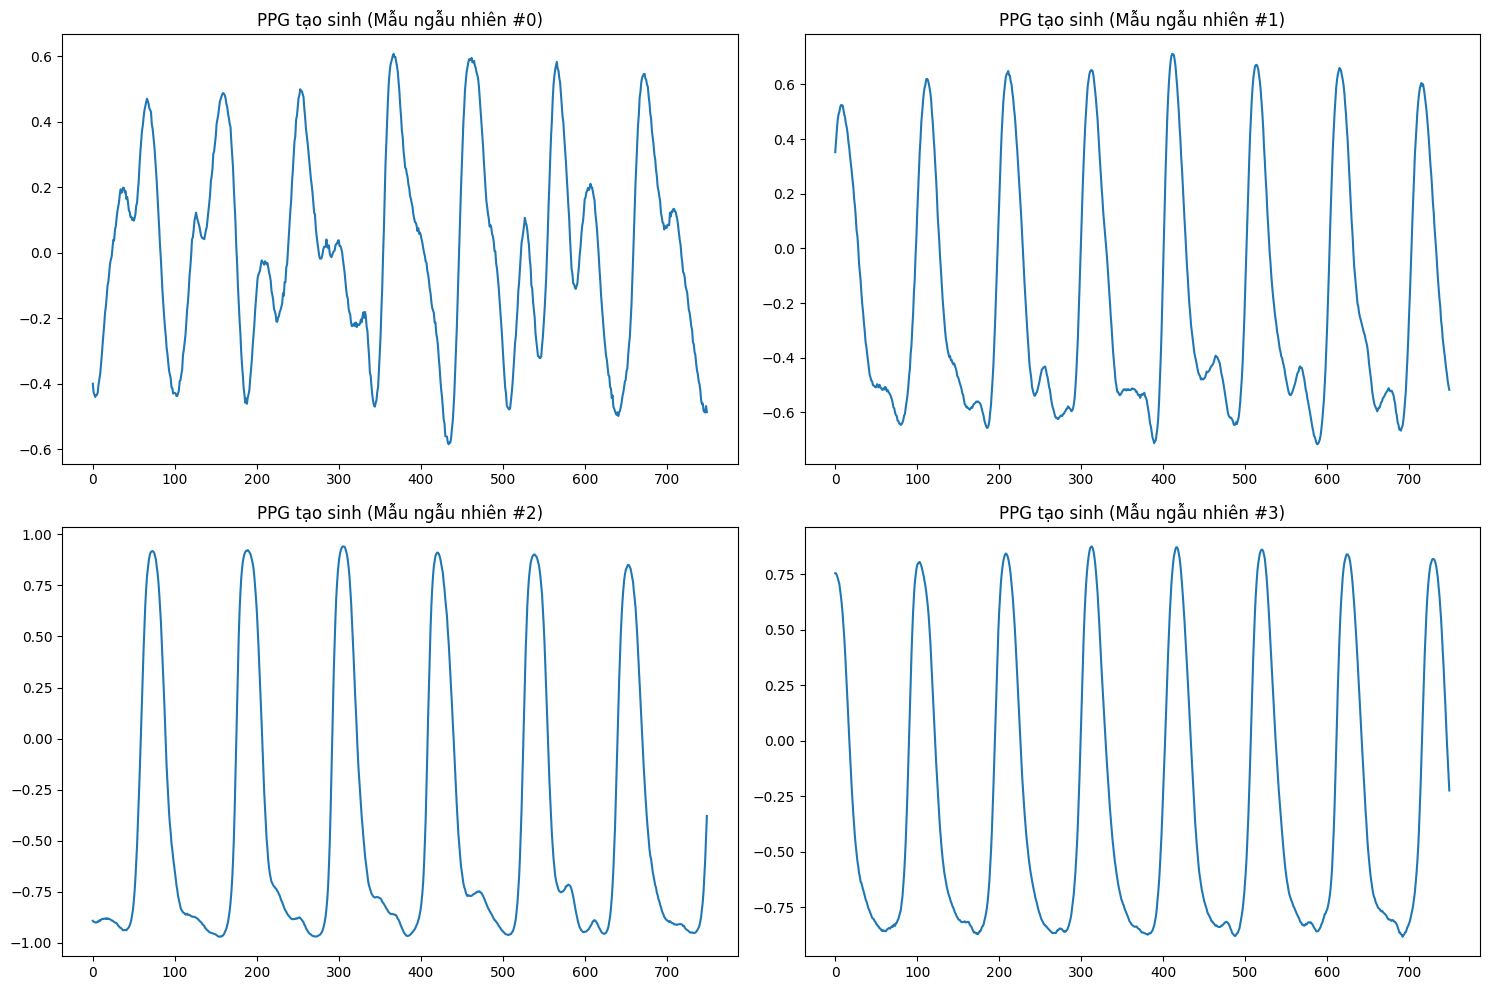

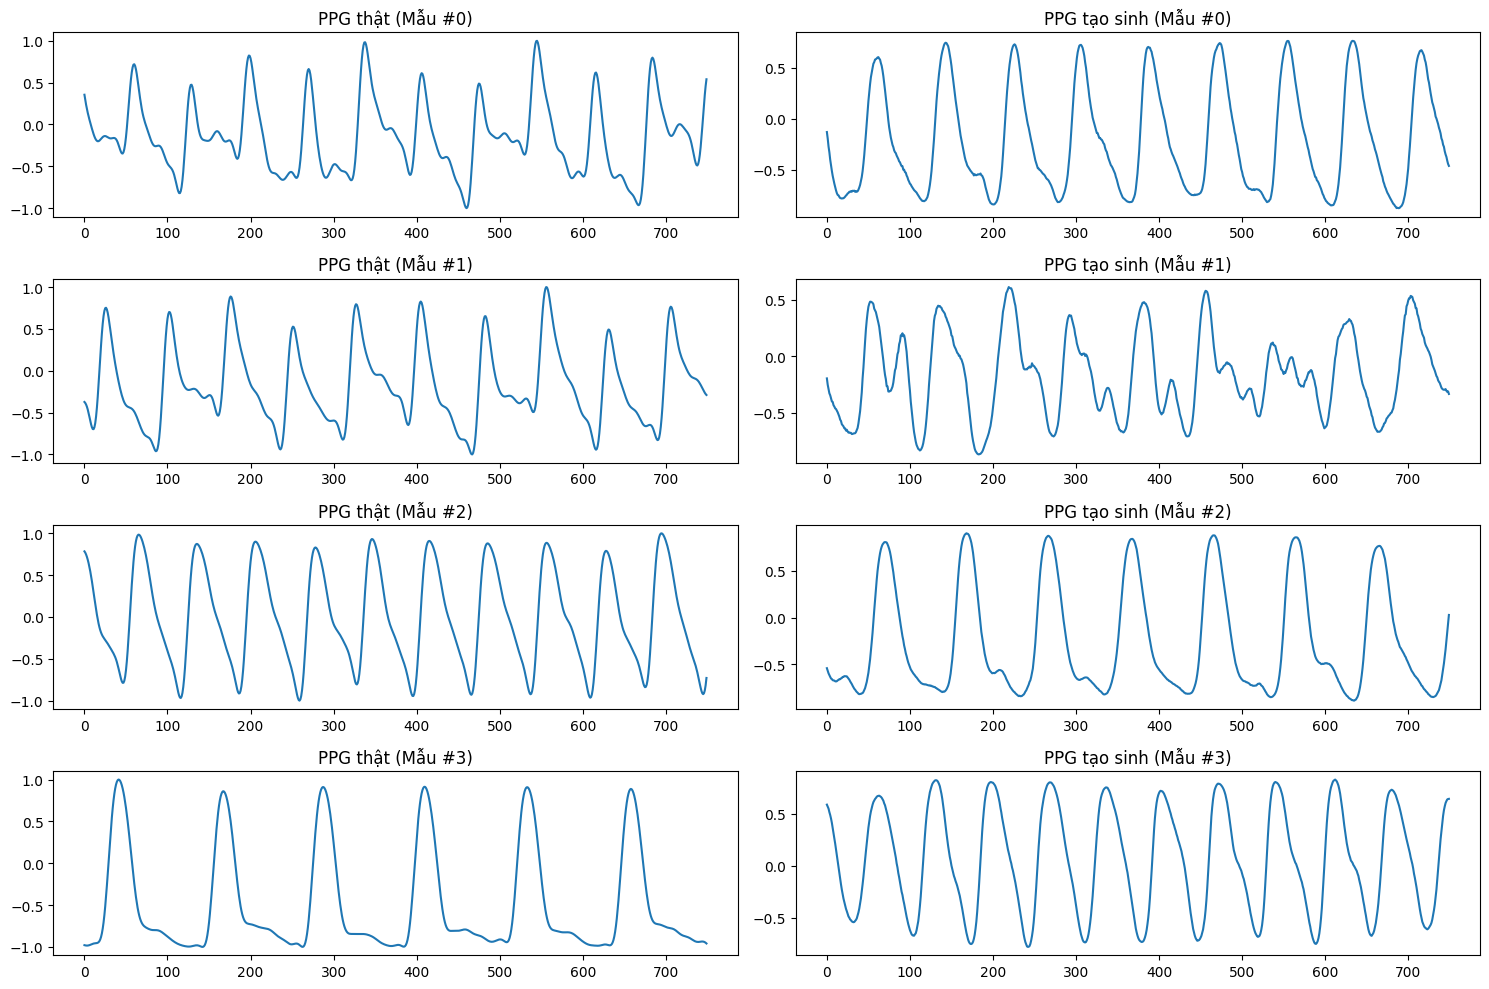

In [35]:
# Hàm đánh giá và tạo sinh PPG
def evaluate_generation(vae, device):
    """
    Tạo sinh PPG ngẫu nhiên

    Args:
        vae: mô hình VAE đã huấn luyện
        device: thiết bị tính toán (CPU/GPU)

    Returns:
        generated: tín hiệu PPG được tạo sinh
    """
    vae.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated = vae.decoder(z)
    return generated

# Lấy một số mẫu từ tập test để so sánh
n_samples = 5
test_samples = []

# Lấy một số mẫu từ tập test
for i, (data,) in enumerate(test_loader):
    if i >= n_samples:
        break
    test_samples.append(data[0])

# Tạo sinh PPG ngẫu nhiên
generated_samples = []
for _ in range(n_samples):
    generated = evaluate_generation(vae, device)
    generated_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị so sánh giữa PPG thật và PPG tạo sinh
plt.figure(figsize=(15, 12))
for i in range(n_samples):
    # Vẽ PPG thật
    plt.subplot(n_samples, 2, 2*i+1)
    plt.plot(test_samples[i].cpu().numpy())
    plt.title(f'PPG thật (Mẫu #{i})')

    # Vẽ PPG tạo sinh
    plt.subplot(n_samples, 2, 2*i+2)
    plt.plot(generated_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu #{i})')

plt.tight_layout()
plt.show()

# Tạo sinh PPG với các mẫu ngẫu nhiên
n_random_samples = 4
generated_random_samples = []
for _ in range(n_random_samples):
    generated = evaluate_generation(vae, device)
    generated_random_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị PPG tạo sinh với các mẫu ngẫu nhiên
plt.figure(figsize=(15, 10))
for i in range(n_random_samples):
    plt.subplot(2, 2, i+1)
    plt.plot(generated_random_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu ngẫu nhiên #{i})')

plt.tight_layout()
plt.show()

# So sánh nhiều mẫu PPG thật và tạo sinh
plt.figure(figsize=(15, 10))
selected_samples = []
selected_indices = []

# Lấy 4 mẫu ngẫu nhiên từ tập test
for i, (data,) in enumerate(test_loader):
    if len(selected_samples) >= 4:
        break
    for j in range(len(data)):
        if len(selected_samples) < 4:
            selected_samples.append(data[j])
            selected_indices.append(i*len(data)+j)

# Tạo sinh PPG ngẫu nhiên
generated_selected = []
for _ in range(len(selected_samples)):
    generated = evaluate_generation(vae, device)
    generated_selected.append(generated.cpu().squeeze(0))

# Vẽ đồ thị so sánh
for i in range(len(selected_samples)):
    plt.subplot(4, 2, 2*i+1)
    plt.plot(selected_samples[i].cpu().numpy())
    plt.title(f'PPG thật (Mẫu #{selected_indices[i]})')

    plt.subplot(4, 2, 2*i+2)
    plt.plot(generated_selected[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu #{i})')

plt.tight_layout()
plt.show()

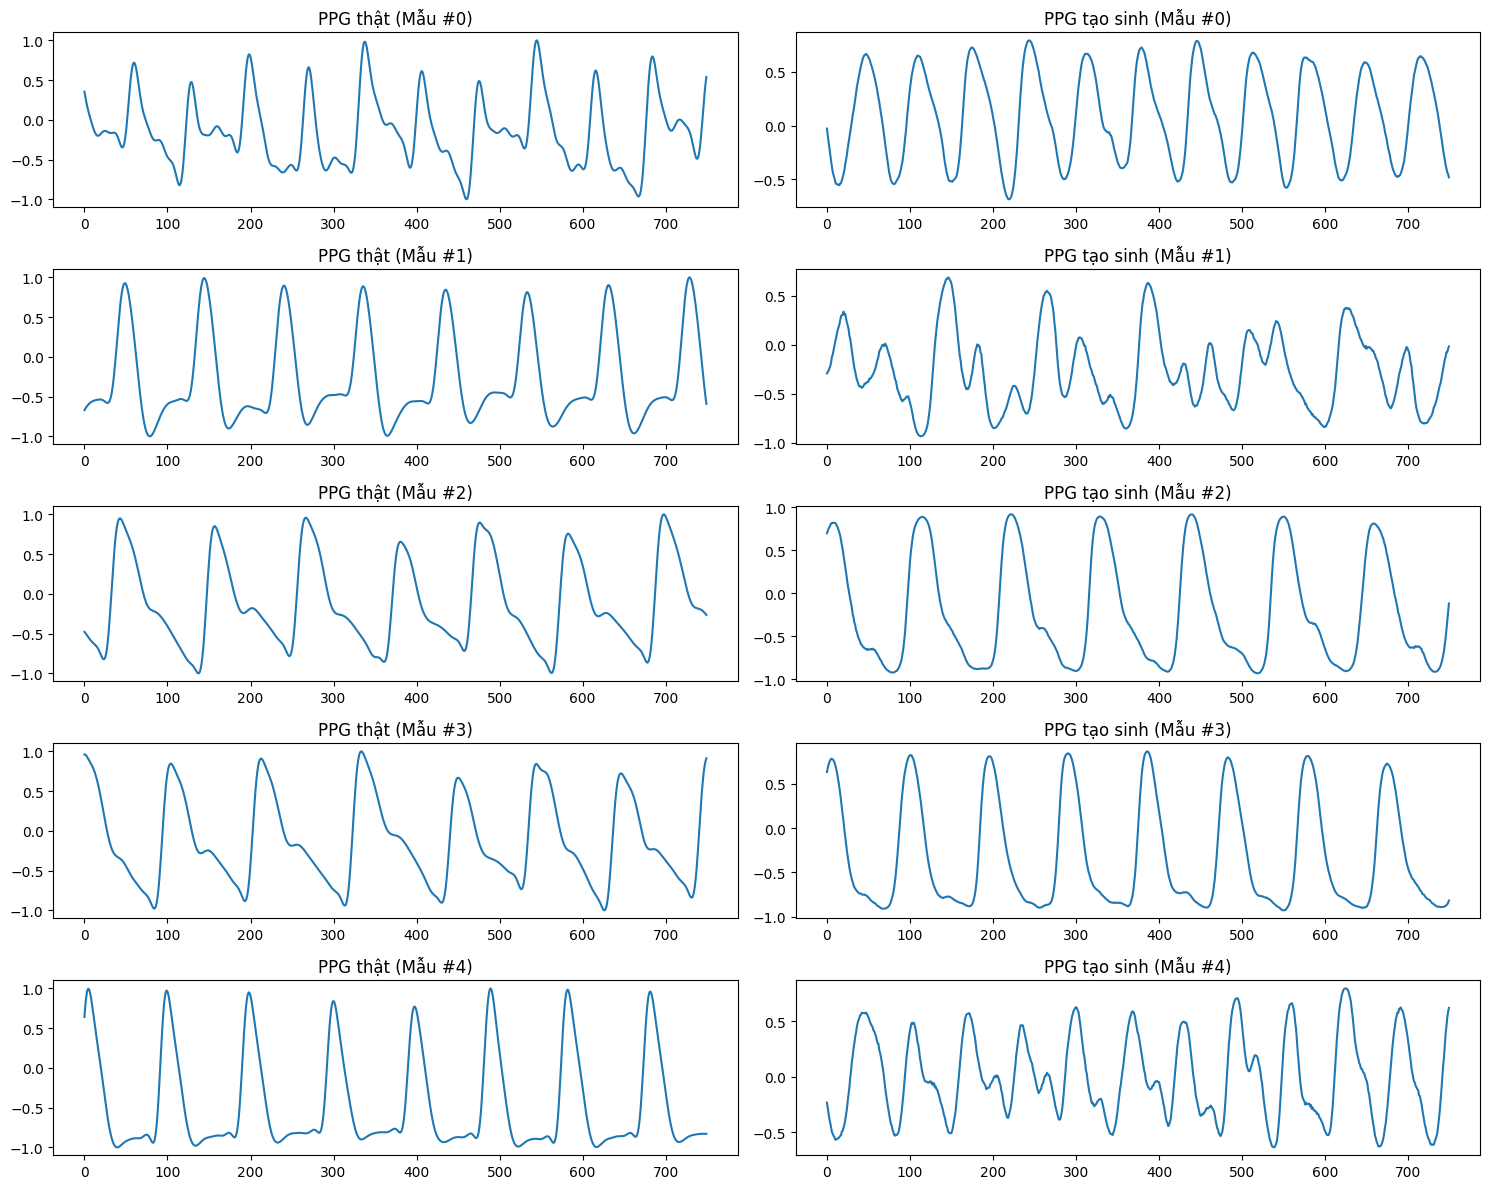

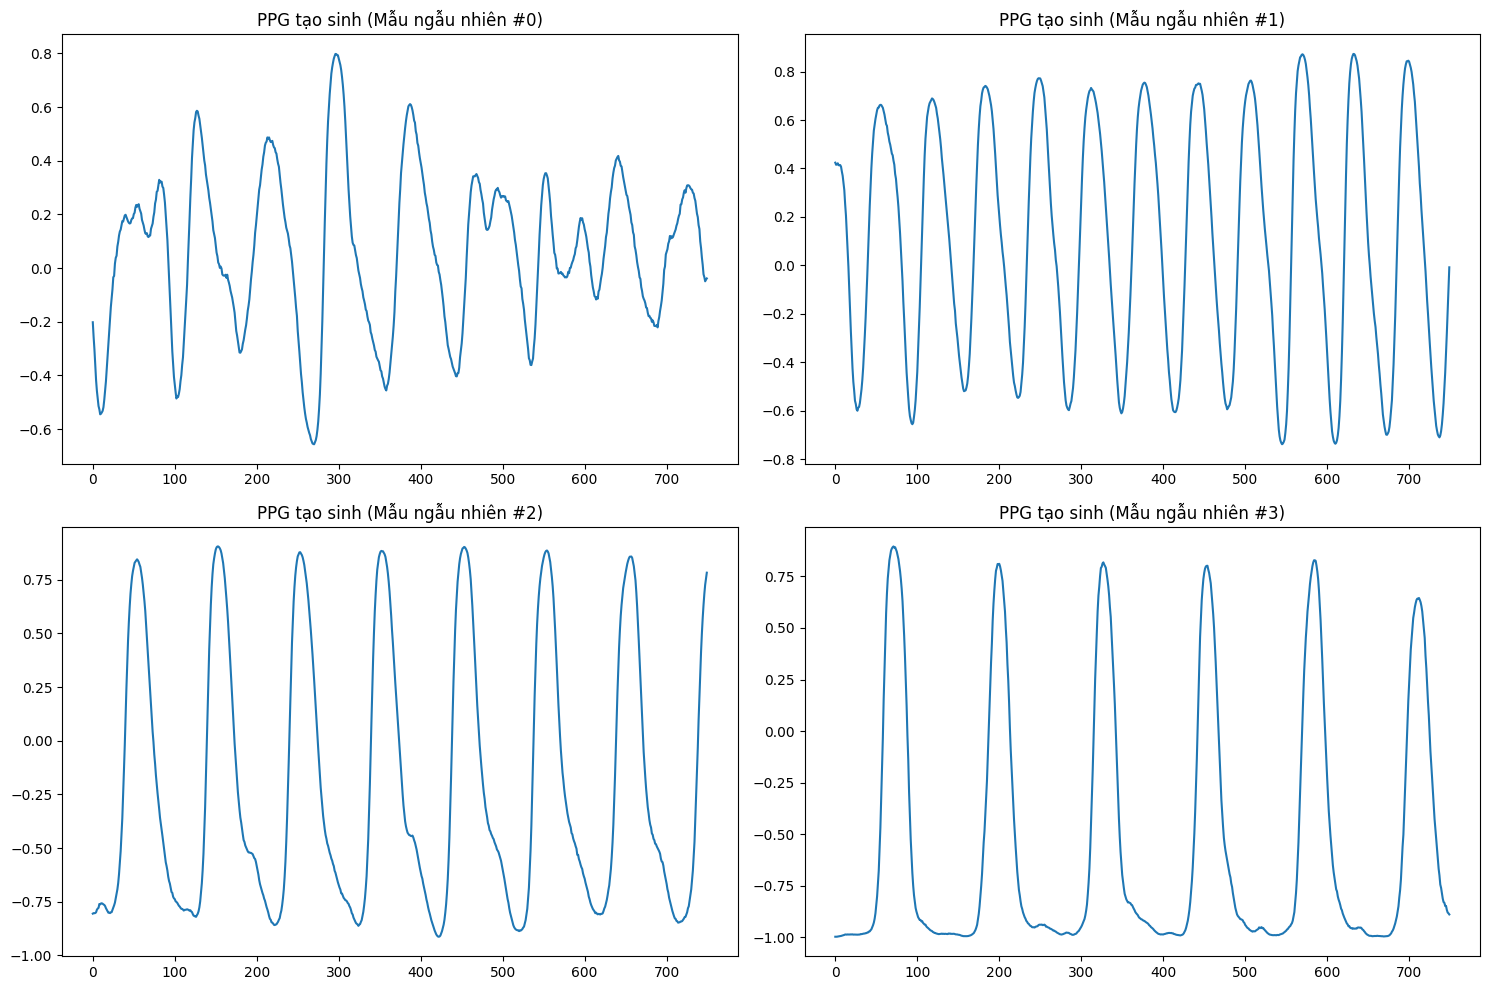

In [36]:
# Hàm đánh giá và tạo sinh PPG
def evaluate_generation(vae, device):
    """
    Tạo sinh PPG ngẫu nhiên

    Args:
        vae: mô hình VAE đã huấn luyện
        device: thiết bị tính toán (CPU/GPU)

    Returns:
        generated: tín hiệu PPG được tạo sinh
    """
    vae.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated = vae.decoder(z)
    return generated

# Lấy một số mẫu từ tập test để so sánh
n_samples = 5
test_samples = []

# Lấy một số mẫu từ tập test
for i, (data,) in enumerate(test_loader):
    if i >= n_samples:
        break
    test_samples.append(data[0])

# Tạo sinh PPG ngẫu nhiên
generated_samples = []
for _ in range(n_samples):
    generated = evaluate_generation(vae, device)
    generated_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị so sánh giữa PPG thật và PPG tạo sinh
plt.figure(figsize=(15, 12))
for i in range(n_samples):
    # Vẽ PPG thật
    plt.subplot(n_samples, 2, 2*i+1)
    plt.plot(test_samples[i].cpu().numpy())
    plt.title(f'PPG thật (Mẫu #{i})')

    # Vẽ PPG tạo sinh
    plt.subplot(n_samples, 2, 2*i+2)
    plt.plot(generated_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu #{i})')

plt.tight_layout()
plt.show()

# Tạo sinh PPG với các mẫu ngẫu nhiên
n_random_samples = 4
generated_random_samples = []
for _ in range(n_random_samples):
    generated = evaluate_generation(vae, device)
    generated_random_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị PPG tạo sinh với các mẫu ngẫu nhiên
plt.figure(figsize=(15, 10))
for i in range(n_random_samples):
    plt.subplot(2, 2, i+1)
    plt.plot(generated_random_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu ngẫu nhiên #{i})')

plt.tight_layout()
plt.show()